# 2021-11-16 Adding support for agent width and length

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/64a91a49a7e322e755546f225f9b56b5c54d30ea (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

## Main modification

I have now finally gotten rid of `sc_scenario.SHARED_PARAMS.d_C`, in favour of specifying widths and lengths for agents, and using this to define a "collision distance" for each agent, which is the distance from the conflict point at which it becomes possible for the agent to collide with the other agent - in other words this collision distance depends on the dimensions of both agents:

$$
d_C = \frac{W_\mathrm{oth}}{2} + \frac{L_\mathrm{ego}}{2}
$$

as now implemented in `sc_scenario_helper.get_agent_coll_dist()`. Note that the above expression is based on the position of each agent being the centre point of the agent - which is the convention I have adopted.

Based on some googling, I think reasonable dimensions are 0.8 $\times$ 0.8 m for the pedestrian (allowing some movement of arms and legs around the trunk), and 1.8 $\times$ 4.2 m for the car.

As part of this change, I am now also always assuming that the "effective width" used by the `oVAl` model is equal to the actual width of the agent. Note that the width values suggested above are the same as the effective width values used in the deterministic fits so far.

## Another modification - apparent bug in the non-affordance based value calculations

While modifying `sc_scenario.py` to implement the width/length support, I realised that `SCAgent.get_value_of_state_for_agent()`, used for the original, non-affordance-based (non-`oVA`) value calculations, had a condition 
    
    elif self.ctrl_type is CtrlType.ACCELERATION:
        [subtracting value for collision course]

which is incorrect - it should check whether the control type of the agent for which value was being calculated was of that type. I have corrected this now. This should have an impact for models which only estimate value for the other agent, i.e. `oBEv` model variants - but only for non-`oVA`. With the bug, these non-`oVA`, but `oBEv` models, will effectively have modelled the pedestrian as thinking that the car always had $k_{sc} = 0$.

## Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
if not (parent_path in sys.path):
    sys.path.append(parent_path)
print(sys.path)

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
import sc_scenario_perception
from sc_scenario_helper import CtrlType

['C:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\python39.zip', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\DLLs', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64', '', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\Pythonwin', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'C:\\GITHUB\\COMMOTIONSFramework']


## Unit tests, reproducing earlier results

### Basics - check!

Just the base model, no interaction.

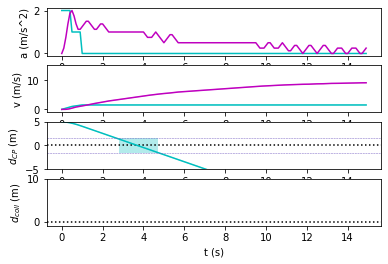

In [2]:
NAMES = ('P', 'V')
WIDTHS = (1.5, 1.5) # setting widths/lengths corresponding to the old default
LENGTHS = (1.5, 1.5) # setting sc_scenario.SHARED_PARAMS.d_C = 1.5
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = sc_scenario.SCSimulation(
        CTRL_TYPES, WIDTHS, LENGTHS, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

Baseline kinematics, base model. Also ok.

Initial car distance 30 m:


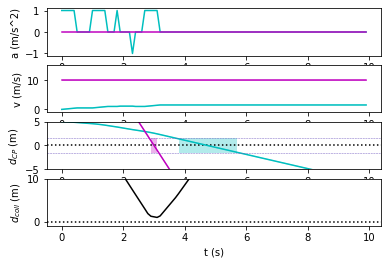

Initial car distance 40 m:


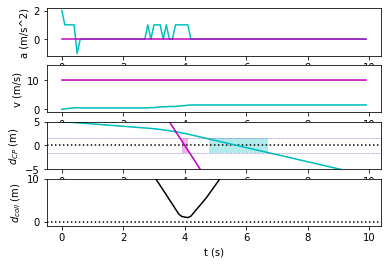

Initial car distance 50 m:


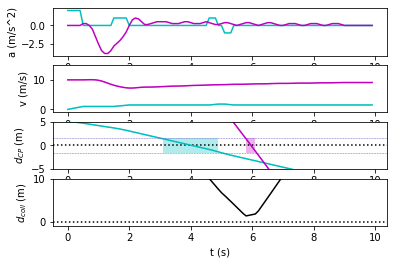

In [3]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), 
                            plot_beh_probs = False, plot_beh_activs = False, 
                            plot_beh_accs = False, plot_looming = False, 
                            ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = sc_scenario.SCSimulation(
                CTRL_TYPES, WIDTHS, LENGTHS, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs,
                              looming = plot_looming)

run_baseline_kinematics()

And here is the same after restoring the pre-safety-margin settings. Again ok.

Initial car distance 30 m:


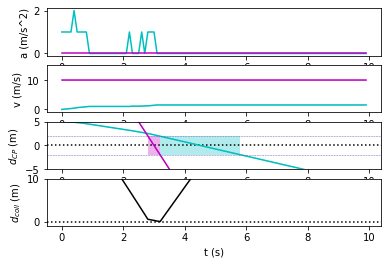

Initial car distance 40 m:


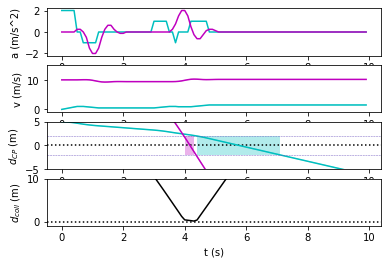

Initial car distance 50 m:


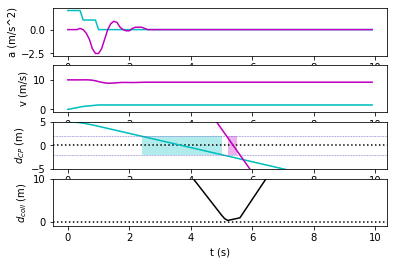

In [4]:
WIDTHS = (2, 2) # setting widths/lengths corresponding to the old default
LENGTHS = (2, 2) # setting sc_scenario.SHARED_PARAMS.d_C = 2
params.T_s = 0
params.D_s = 0
run_baseline_kinematics()

### Testing the `oBEo` etc sequence - check!

Getting back the same results as in the 2021-11-09 notes:

Turning on oBEo:
Initial car distance 40 m:


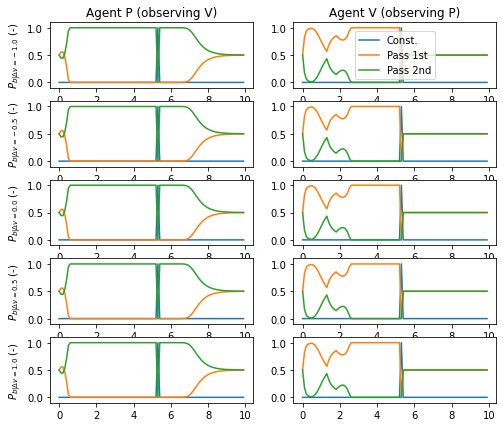

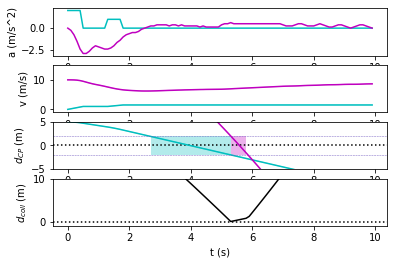

Turning on oBEv:
Initial car distance 40 m:


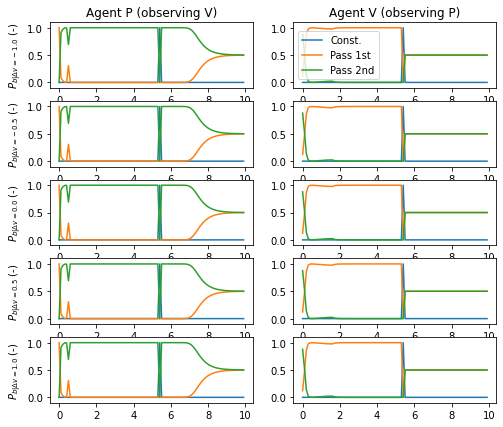

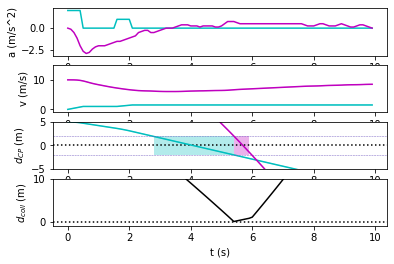

Turning on oAI:
Initial car distance 40 m:


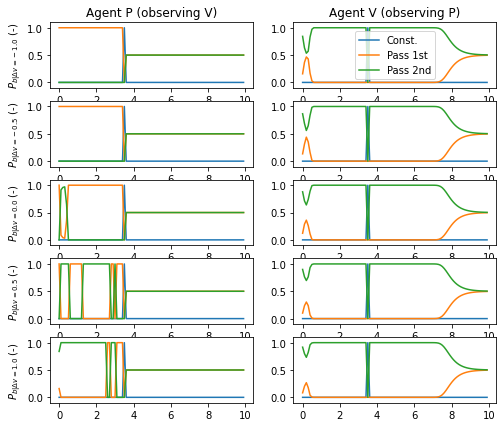

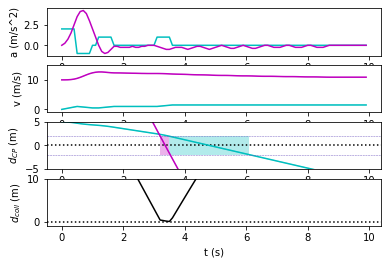

In [5]:
params.T_O1 = 0.1 
params.T_Of = 0.5
params.sigma_O = 0.01
params.beta_V = 160

def run_oBEo_etc_seq():
    global optional_assumptions
    print('Turning on oBEo:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
    print('Turning on oBEv:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
    print('Turning on oAI:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True, oAI = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
run_oBEo_etc_seq()

## Effect of setting more realistic agent dimensions

### Base model

We can see that the base model simulations above change a little, but not massively, when we set more realistic agent dimensions:

Initial car distance 30 m:


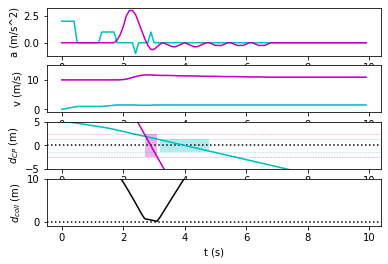

Initial car distance 40 m:


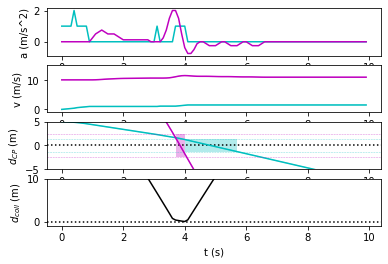

Initial car distance 50 m:


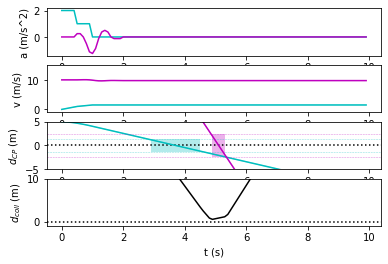

In [6]:
WIDTHS = (0.8, 1.8)
LENGTHS = (0.8, 4.2)
optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN)
run_baseline_kinematics()

### The oBEo etc sequence

With the adjusted agent dimensions, this sequence of simulations changes a bit more, changing the order of access compared to previously in the `oBEooBEv` simulation, but overall things look sensible, and we still get vehicle priority assertion from the `oBEooBEvoAI` model.

Turning on oBEo:
Initial car distance 40 m:


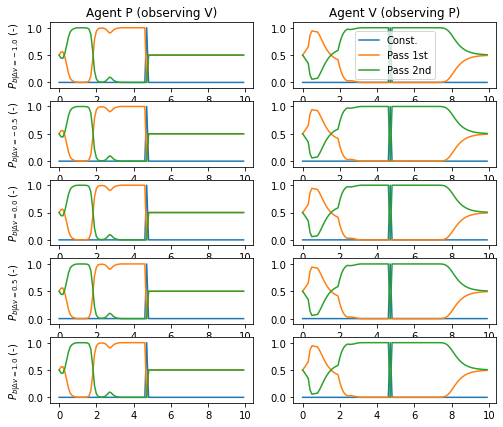

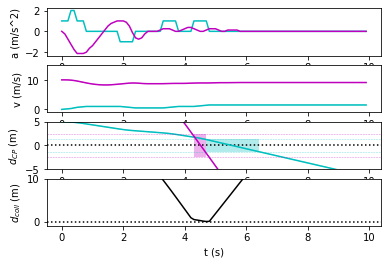

Turning on oBEv:
Initial car distance 40 m:


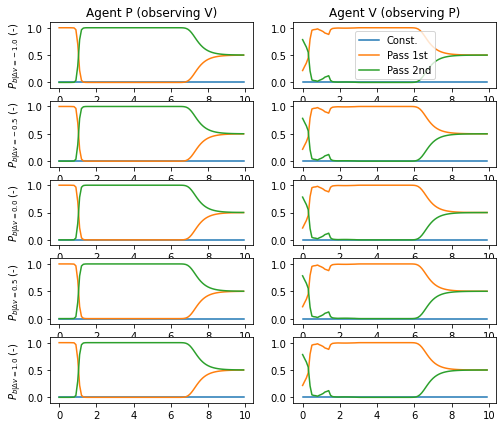

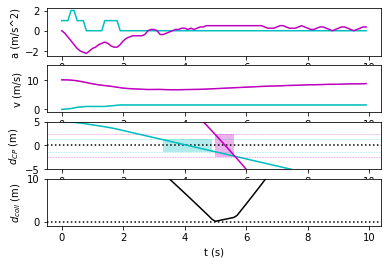

Turning on oAI:
Initial car distance 40 m:


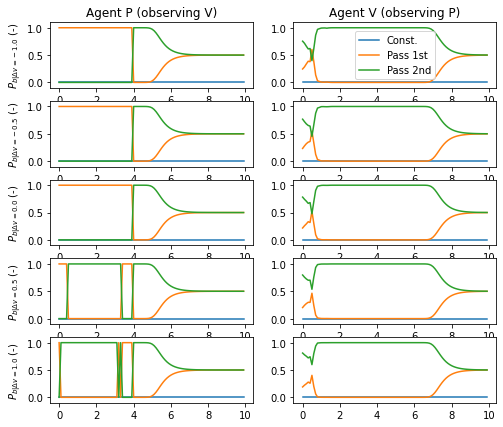

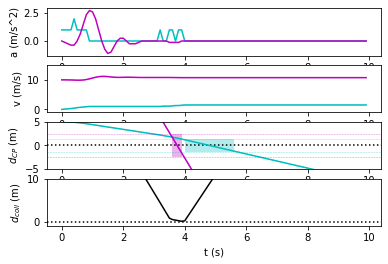

In [7]:
run_oBEo_etc_seq()

## Conclusions

All seems fine so far. I also want to rerun the deterministic fits with the same small grid as in the 2021-10-28 notes, to see the impact of the agent dimensions change and the small bug fix for the non-`oVA`+`oBEv` models.